In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import utilities
from gcn_model import GCNModel
import torch

In [18]:
data_folder = "simulations/splat_0.7_de_rq/"
# get labels
data_path = data_folder + "query_counts.csv"
tools = ["sctype","scsorter","scina","singler", "scpred"]
#tools = ["scsorter","scina","singler"]
ref_path = data_folder + "ref_counts.csv"
ref_label_path = data_folder + "ref_labels.csv"
marker_path = data_folder + "markers.txt"
if os.path.exists(data_folder + "preds.csv"):
    all_labels = pd.read_csv(data_folder + "preds.csv", index_col=0)
    if all_labels.shape[1] != len(tools): 
        all_labels = all_labels[tools]
        #raise Exception("wrong amount of tools in file")
else:
    all_labels = utilities.label_counts(data_path,tools,ref_path,ref_label_path,marker_path)

# read in dataset
X = pd.read_csv(data_path, index_col=0)
X, keep_cells,_,_ = utilities.preprocess(np.array(X), scale=False, comps=500)

all_labels = all_labels.loc[keep_cells,:]

_,marker_names = utilities.read_marker_file(marker_path)

all_labels_factored = utilities.factorize_df(all_labels, marker_names)
encoded_labels = utilities.encode_predictions(all_labels_factored)

meta_path = data_folder + "query_meta.csv"
metadata = pd.read_csv(meta_path, index_col=0)
real_y = pd.factorize(metadata['Group'], sort=True)[0]
real_y = real_y[keep_cells]

In [11]:
np.arange(0.01,1,0.1)

array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91])

In [15]:
thresh = []
conf_acc = []
conf_cells = []
for i in np.arange(0.01,1,0.1):
    thresh.append(i)
    confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = i)
    train_nodes = np.where(confident_labels != -1)[0]
    test_nodes = np.where(confident_labels == -1)[0]
    conf_cells.append(len(train_nodes))
    conf_acc.append(utilities.pred_accuracy(confident_labels[train_nodes], real_y[train_nodes]))


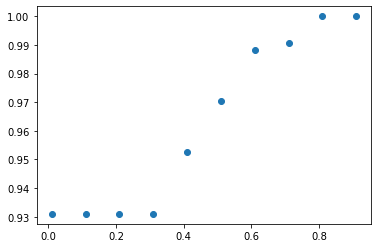

In [16]:
plt.scatter(thresh, conf_acc)

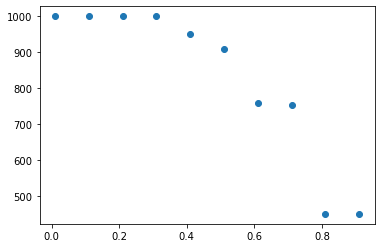

In [17]:
plt.scatter(thresh, conf_cells)

In [22]:
thresh = []
accs = []
for i in np.arange(0.31,1,0.1):
    thresh.append(i)
    confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = i)
    train_nodes = np.where(confident_labels != -1)[0]
    test_nodes = np.where(confident_labels == -1)[0]

    dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

    test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

    m = GCNModel("configs/2_40.txt", 2, dropout=0.0)
    m.train(dataloader, 100, verbose=False)

    acc,_,_,_,_,_ = m.validation_metrics(test_dataloader, train_nodes, test_nodes)
    accs.append(acc)

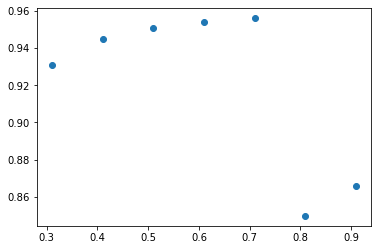

In [23]:
plt.scatter(thresh, accs)

In [30]:
thresh = []
accs = []
for i in np.arange(0.31,1,0.1):
    thresh.append(i)

    # use these as validation set 
    ultra_confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = .9)
    ultra_val_nodes = np.where(ultra_confident_labels != -1)[0]

    confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = i)
    confident_labels[ultra_val_nodes] = -1
    train_nodes = np.where(confident_labels != -1)[0]
    test_nodes = np.where(confident_labels == -1)[0]

    dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

    test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(ultra_confident_labels))
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

    m = GCNModel("configs/2_40.txt", 2, dropout=0.0)
    m.train(dataloader, 50, verbose=False)

    _,_,acc,_,_,_ = m.validation_metrics(test_dataloader, ultra_val_nodes, test_nodes)
    accs.append(acc)

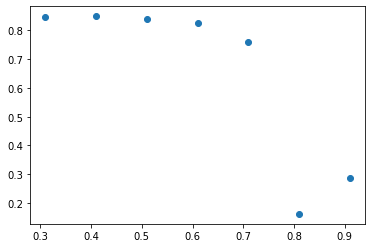

In [31]:
plt.scatter(thresh, accs)